In [199]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

train = pd.read_csv('/Users/colingibbons-fly/Downloads/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/Users/colingibbons-fly/Downloads/house-prices-advanced-regression-techniques/test.csv')

In [200]:
#Feature Engineerinng
train['TotalSF'] = train['1stFlrSF'] + train['2ndFlrSF'] + train['TotalBsmtSF']
train['AgeAtSale'] = train['YrSold'] - train['YearBuilt']
train['Remodeled'] = (train['YearRemodAdd'] != train['YearBuilt']).astype(int)
train['sqf_qual'] = train['OverallQual'] * train['TotalSF']
train['TotalBath'] = (
    train['FullBath'] + 
    0.5 * train['HalfBath'] + 
    train['BsmtFullBath'] + 
    0.5 * train['BsmtHalfBath']
)

test['TotalSF'] = test['1stFlrSF'] + test['2ndFlrSF'] + train['TotalBsmtSF']
test['AgeAtSale'] = test['YrSold'] - test['YearBuilt']
test['Remodeled'] = (test['YearRemodAdd'] != test['YearBuilt']).astype(int)
test['sqf_qual'] = test['OverallQual'] * test['TotalSF']
test['TotalBath'] = (
    test['FullBath'] + 
    0.5 * test['HalfBath'] + 
    test['BsmtFullBath'] + 
    0.5 * test['BsmtHalfBath']
)

In [201]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Drop the target variable column
train_features = train.drop(columns=['SalePrice'])

# Define numerical and categorical attributes based on the modified training data
num_attribs = [col for col in train_features if train_features[col].dtype != 'object']
cat_attribs = [col for col in train_features if train_features[col].dtype == 'object']

# Define the numerical and categorical pipelines
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine pipelines
full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', cat_pipeline, cat_attribs),
])

# Apply the pipeline to training and testing data
X_train_prepared = full_pipeline.fit_transform(train_features)
X_test_prepared = full_pipeline.transform(test)

# Convert to DataFrame if needed
X_train_prepared_df = pd.DataFrame(X_train_prepared.toarray(), columns=full_pipeline.get_feature_names_out())
X_test_prepared_df = pd.DataFrame(X_test_prepared.toarray(), columns=full_pipeline.get_feature_names_out())

# Extract the target variable
y_train = train['SalePrice']

In [202]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_prepared, y_train, test_size=0.2, random_state=42)

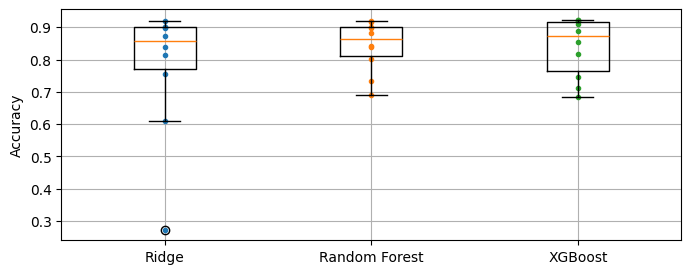

In [203]:
from sklearn.model_selection import cross_val_score

#Ridge Model
from sklearn.linear_model import Ridge
ridge = Ridge()
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_val)
ridge_score = cross_val_score(ridge, X_train, y_train, cv=10)

#Random Forest Regressor Model
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(X_train, y_train)
y_pred = forest_reg.predict(X_val)
forest_reg_score = cross_val_score(forest_reg, X_train, y_train, cv=10)

#XGBoost
from xgboost import XGBRegressor
xgb_reg = XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)
xgb_reg_score = cross_val_score(xgb_reg, X_train, y_train, cv=10)

#Create a boxplot evaluating the models performances
plt.figure(figsize=(8, 3))
plt.plot([1]*10, ridge_score, ".")
plt.plot([2]*10, forest_reg_score, ".")
plt.plot([3]*10, xgb_reg_score, ".")
plt.boxplot([ridge_score, forest_reg_score, xgb_reg_score], labels=("Ridge", "Random Forest", "XGBoost"))
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

In [204]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

ridge = Ridge(random_state=42)
param_grid = {
    'alpha': [0.1, 1, 10, 50, 100, 200, 500],     
    'tol': [1e-3, 1e-4, 1e-5]                    
}

ridge_grid_search = GridSearchCV(ridge, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

ridge_grid_search.fit(X_train, y_train)
ridge_final_model = ridge_grid_search.best_estimator_
ridge_final_predictions = ridge_final_model.predict(X_val)
ridge_final_mse = mean_squared_error(y_val, ridge_final_predictions)
ridge_final_rmse =  np.sqrt(ridge_final_mse)
print(ridge_final_rmse)

30628.56180428348


In [205]:
forest_reg = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [100, 200, 500, 1000],           
    'max_depth': [None, 10, 20, 30, 50],                              
    'max_features': [10,25, 40, 75, 100]         
}

forest_grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

forest_grid_search.fit(X_train, y_train)    
forest_final_model = forest_grid_search.best_estimator_
forest_final_predictions = forest_final_model.predict(X_val)
forest_final_mse = mean_squared_error(y_val, forest_final_predictions)
forest_final_rmse =  np.sqrt(forest_final_mse)
print(forest_final_rmse)

29824.949951468618


In [206]:
xgb_reg = XGBRegressor(random_state=42)
param_grid = {
    'n_estimators': [100, 500, 1000],                
    'max_depth': [3, 5, 7, 10],                              
    'gamma': [0, 0.1, 0.3, 0.5],                     
                 
}

xgb_grid_search = GridSearchCV(xgb_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

xgb_grid_search.fit(X_train, y_train)    
xgb_final_model = xgb_grid_search.best_estimator_
xgb_final_predictions = xgb_final_model.predict(X_val)
xgb_final_mse = mean_squared_error(y_val, xgb_final_predictions)
xgb_final_rmse =  np.sqrt(xgb_final_mse)
print(xgb_final_rmse)

26651.904383934


In [212]:
predictions = xgb_final_model.predict(X_test_prepared)

submission = pd.DataFrame({
    'Id': test['Id'],
    'SalePrice': predictions
})

# Save the DataFrame to a CSV file
submission.to_csv('housing_kaggle_submission.csv', index=False)

submission.head()

,Id,SalePrice
0,1461,123485.539062
1,1462,164474.781250
2,1463,172645.656250
3,1464,186818.578125
4,1465,186346.437500
